<a href="https://colab.research.google.com/github/leeIITM/DSA_with_Python/blob/main/Copy_of_copy_of_mvts_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch #as th
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#loading data
def load(file_name):
    with open(file_name, 'rb') as fp:
        obj = pickle.load(fp)
    return obj



#set data path and load data
datapath ="/content/drive/MyDrive/flare_prediction_mvts_data.pck"
labelpath ="/content/drive/MyDrive/flare_prediction_labels.pck"

mvts_1540=load(datapath)
print(mvts_1540[0].shape)
labels_1540=load(labelpath)

#Check data
print("MVTS dataset shape: ", mvts_1540.shape, "  type: ", type(mvts_1540)) # (1540, 33, 60)
print("Labels shape: ", labels_1540.shape, "  type: ", type(labels_1540))     # (1540,)
print("unique labels: ", np.unique(labels_1540))# [0 1 2 3]


(33, 60)
MVTS dataset shape:  (1540, 33, 60)   type:  <class 'numpy.ndarray'>
Labels shape:  (1540,)   type:  <class 'numpy.ndarray'>
unique labels:  [0 1 2 3]


Graph construction

In [ ]:

#Binary classification -> Data label conversion to BINARY class
def get_binary_labels_from(labels_str):
    tdf = pd.DataFrame(labels_str, columns = ['labels'])
    data_classes= [0, 1, 2, 3]
    d = dict(zip(data_classes, [0, 0, 1, 1]))
    arr = tdf['labels'].map(d, na_action='ignore')
    return arr.to_numpy()

#un-comment next line for Binary classification experiment
#labels_1540 = get_binary_labels_from(labels_1540)

# data preparation: first 25 nodes only

def extract_num_nodes(mvts, num_nodes):
    #trans = GetTransposed2D(mvts)
    reducedTrans = []
    for i in range(len(mvts)):
          temp = mvts[i]
          #=report['accuracy']
          reducedTrans.append(temp[0:num_nodes, :])

    return np.array(reducedTrans)

mvts_1540 = extract_num_nodes(mvts_1540, 25)

#Stratified train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mvts_1540, labels_1540, test_size=0.3, random_state=0, stratify=labels_1540)

#Takes 3D array(x,y,z) >> transpose(y,z) >> return (x,z,y)
def GetTransposed2D(arrayFrom):
    toReturn = []
    alen = arrayFrom.shape[0]
    for i in range(0, alen):
        toReturn.append(arrayFrom[i].T)

    return np.array(toReturn)

#Takes 3D array(x,y,z) >> Flatten() >> return (y,z)
def Make2D(array3D):
    toReturn = []
    x = array3D.shape[0]
    y = array3D.shape[1]
    for i in range(0, x):
        for j in range(0, y):
            toReturn.append(array3D[i,j])

    return np.array(toReturn)

#Transform instance(92400, 33) into(1540x60x33)
def Get3D_MVTS_from2D(array2D, windowSize):
    arrlen = array2D.shape[0]
    mvts = []
    for i in range(0, arrlen, windowSize):
        mvts.append(array2D[i:i+windowSize])

    return np.array(mvts)

from sklearn.preprocessing import StandardScaler
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
def GetStandardScaler(data2d):
    scaler = StandardScaler()
    scaler = scaler.fit(data2d)
    return scaler

def GetStandardScaledData(data2d):
    scaler = StandardScaler()
    scaler = scaler.fit(data2d)
    #print(scaler.mean_)
    data_scaled = scaler.transform(data2d)
    return data_scaled

def transform_scale_data(data3d, scaler):
    trans = GetTransposed2D(data3d)
    data2d = Make2D(trans)
    data_scaled = scaler.transform(data2d)
    mvts_scalled = Get3D_MVTS_from2D(data_scaled, data3d.shape[2])#,60)
    transBack = GetTransposed2D(mvts_scalled)
    return transBack

def build_edge_index_tensor(adj):
  num_nodes = adj.shape[0]
  source_nodes_ids, target_nodes_ids = [], []
  for i in range(num_nodes):
    for j in range(num_nodes):
      if(adj[i,j]==1):
        source_nodes_ids.append(i)
        target_nodes_ids.append(j)
  edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))
  edge_index_tensor = torch.from_numpy(edge_index)
  return edge_index_tensor

def GetGraphAdjMtrx(squareMtx, thresolds, keep_weights=False): #Apply Thresolds to squareMtx
    graphs = []
    mtxLen = squareMtx.shape[0]
    for thr in thresolds:
        m = np.zeros((mtxLen,mtxLen))#r = []
        for i in range(0,mtxLen):
            for j in range(0,mtxLen):
                if i == j:# or squareMtx[i,j] > thr:
                    m[i,j] = 1
                elif squareMtx[i,j] > thr:
                  if keep_weights == True:
                    m[i,j] = squareMtx[i,j]
                  else:
                    m[i,j] = 1
        graphs.append(m)#np.array(r))
    return graphs[0]

def get_edge_index_weight_tensor(adj):
  num_nodes = adj.shape[0]
  source_nodes_ids, target_nodes_ids, edge_weights = [], [], []
  for i in range(num_nodes):
    for j in range(num_nodes):
      if(adj[i,j]>0):
        source_nodes_ids.append(i)
        target_nodes_ids.append(j)
        edge_weights.append(adj[i,j])
  edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))
  edge_index_tensor = torch.from_numpy(edge_index)
  edge_weights_np = np.asarray(edge_weights, dtype=np.float32)
  edge_weights_tensor = torch.from_numpy(edge_weights_np)
  #print(edge_index_tensor)
  #print(edge_weights_tensor)
  return edge_index_tensor, edge_weights_tensor

#data crawler method
def get_adjs_nats(X_3d, num_temporal_split = 4, th = 0):

    num_X = X_3d.shape[0]
    num_nodes = X_3d.shape[1] #25
    len_st = int(X_3d.shape[2] / num_temporal_split) #15

    #populating adjacency matrices and node attributes of train events
    adjs = np.zeros((num_X, num_temporal_split, num_nodes, num_nodes))
    nats = np.zeros((num_X, num_temporal_split, num_nodes, len_st))

    for i in range(num_X):
      #print('Event: ', i)
      mt = X_3d[i].T #X_train[i].T[:,0:25] #consider first 25 solar params
      #mt = normalize_node_attributes(mt) ++++++++++++++++++++++++++++++
      for j in range(num_temporal_split):
        #print('Temporal split: ', j*15, (j+1)*15)
        smt = mt[j*len_st:(j+1)*len_st, : ]# len_st  mt[j*15:(j+1)*15,:]
        c_smt = np.corrcoef(smt.T)
        c_smt[np.isnan(c_smt)]=0
        #for l in range(0, num_nodes-1): #gcnconv will automatically add self loops
        #    c_smt[l,l] = 0
        #smt = normalize_node_attributes(smt)
        nats[i,j,:,:] = smt.T
        adj = GetGraphAdjMtrx(c_smt, [th], True)#get_adj_mat(c_smt, th, True) #change from ex 10

        adjs[i,j,:,:]=adj

    return adjs, nats



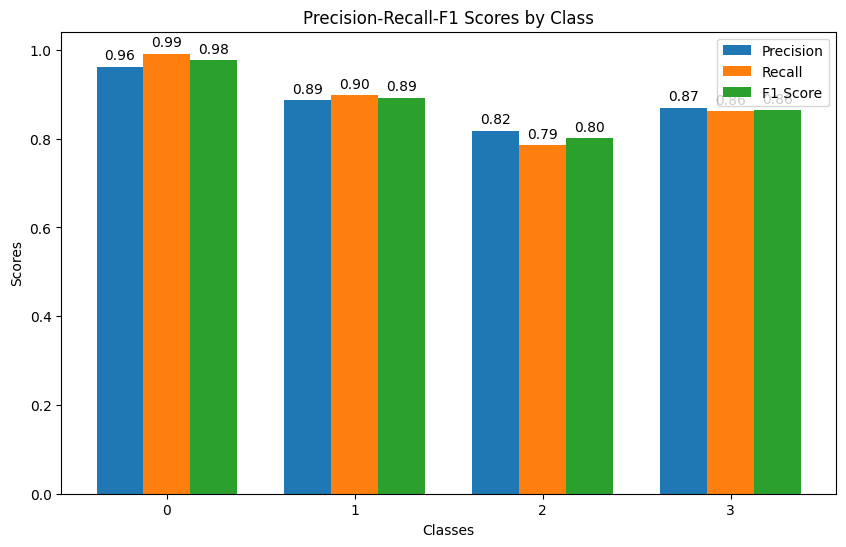

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
# Sample data from your results
classes = [0, 1, 2, 3]
precision = [0.9619, 0.8864, 0.8178, 0.8692]
recall = [0.9913, 0.8980, 0.7850, 0.8612]
f1_score = [0.9762, 0.8917, 0.8005, 0.8642]

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1_score, width, label='F1 Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision-Recall-F1 Scores by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Adding value labels on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2., height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.show()

In [ ]:

#MODELS
#node_emb_dim = graph_emb_dim = window_emb_dim = 4; sequence_emb_dim = 128; class_emb_dim = 4
# (GCN) Node emb -> (mean) Graph emb -> (Flatten, Linear) -> window emb -> (LSTM) -> Temporal sequence emb -> (Linear) Class emb
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data

class MVTS_GCN_RNN(torch.nn.Module):
  def __init__(self, num_nodes, input_dims, num_temporal_split, device, gcn_hidden_dims, node_emb_dims, graph_emb_dims, window_emb_dims, sequence_emb_dims, num_classes):
    super(MVTS_GCN_RNN, self).__init__()
    self.num_nodes = num_nodes
    self.input_dims = input_dims
    self.num_temporal_split = num_temporal_split
    self.device = device
    self.gcn_hidden_dims = gcn_hidden_dims
    self.node_emb_dims = node_emb_dims
    self.graph_emb_dims = graph_emb_dims
    self.window_emb_dims = window_emb_dims
    self.sequence_emb_dims = sequence_emb_dims
    self.num_classes = num_classes

    self.smt2vector = nn.LSTM(num_nodes, sequence_emb_dims)
    self.conv1 = GCNConv(input_dims, gcn_hidden_dims)
    self.conv2 = GCNConv(gcn_hidden_dims, node_emb_dims)
    #self.mean_pool = global_mean_pool(node_emb_dims, num_nodes)
    #self.node2graph = nn.Linear(node_emb_dims, graph_emb_dims)#change from ex 1
    self.seqGraph2window = nn.Linear(sequence_emb_dims+graph_emb_dims, window_emb_dims)
    self.window2sequence = nn.LSTM(window_emb_dims, sequence_emb_dims) #change from ex 1
    self.sequence2class_space = nn.Linear(sequence_emb_dims, num_classes)

  def forward(self, adj_mat_array, node_att_array):
     #adj_mat_array -> (4,1,25,25), node_att_array -> (4,25,15)
     sequence_vectors = torch.zeros((self.num_temporal_split, self.window_emb_dims), device=self.device).double()
     for j in range(self.num_temporal_split):
       node_att = node_att_array[j,:,:]#25*15
       adj_mat = adj_mat_array[j,:,:]
       #prepare for GCNConv
       edge_index_tensor, edge_weights_tensor = get_edge_index_weight_tensor(adj_mat)
       edge_index = edge_index_tensor.to(self.device)
       edge_weights = edge_weights_tensor.to(self.device)
       node_attributes_tensor = torch.from_numpy(node_att)
       x = node_attributes_tensor.to(self.device)#[25,15]

       smvts = torch.t(x)
       small_seq_out, _ = self.smt2vector(smvts.view(len(smvts), 1, -1))#input:[15, 25] , output: [15, 128]
       last_small_seq_out = small_seq_out[len(small_seq_out)-1] #[1,128]
       #GCN on the graph
       x = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_weights)
       x = F.relu(x)
       x = F.dropout(x, training=self.training)
       x = self.conv2(x=x, edge_index=edge_index, edge_weight=edge_weights) #x -> [25, 4]
       x = F.relu(x) #change from ex 10
       x = F.dropout(x, training=self.training) #change from ex 10

       #graph embedding
       x = torch.mean(x, dim=0).view(1,-1) #->[1,4]#mean pool
       graph_vector = x
       seq_graph_vector = torch.cat((last_small_seq_out, graph_vector), dim=1) #[1, 132]

       #window embedding by linear projection
       window_vector = self.seqGraph2window(seq_graph_vector)#[1,64]
       window_vector = F.relu(window_vector)
       sequence_vectors[j,:]=window_vector
     seq_out, _ = self.window2sequence(sequence_vectors.view(len(sequence_vectors), 1, -1))
     last_seq_out = seq_out[len(seq_out)-1] #[1,128]
     #last_seq_out = F.dropout(last_seq_out, training=self.training) #change from ex 10_2
     class_space = self.sequence2class_space(last_seq_out) #[1,4]
     class_scores = F.log_softmax(class_space, dim=1)
     return class_scores


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Checkpoint saving/loading functions
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)

def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Checkpoint loaded: {filename} (epoch {epoch})")
        return epoch, loss
    else:
        print(f"No checkpoint found at '{filename}'")
        return 0, None

# Model parameters
torch.manual_seed(0)

NUM_NODES = 25
INPUT_DIMS = 15
NUM_TEMPORAL_SPLIT = 4
GCN_HIDDEN_DIMS = 4
NODE_EMB_DIMS = 4
GRAPH_EMB_DIMS = NODE_EMB_DIMS
WINDOW_EMB_DIMS = 64
SEQUENCE_EMB_DIMS = 128
NUM_CLASSES = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to get model parameters
def get_model_params():
    model = MVTS_GCN_RNN(NUM_NODES, INPUT_DIMS, NUM_TEMPORAL_SPLIT, device, GCN_HIDDEN_DIMS, NODE_EMB_DIMS, GRAPH_EMB_DIMS, WINDOW_EMB_DIMS, SEQUENCE_EMB_DIMS, NUM_CLASSES).to(device).double()
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    return model, loss_function, optimizer

# Function to get accuracy report
def get_accuracy_report_by_running_epochs(Xtrain, ytrain, Xtest, ytest, epochs, epoch_interval):
    numTrain = Xtrain.shape[0]
    numTest = Xtest.shape[0]
    trainAdjs, trainNats = get_adjs_nats(Xtrain, num_temporal_split=NUM_TEMPORAL_SPLIT, th=0)
    testAdjs, testNats = get_adjs_nats(Xtest, num_temporal_split=NUM_TEMPORAL_SPLIT, th=0)

    model, loss_function, optimizer = get_model_params()

    # Load checkpoint
    start_epoch, _ = load_checkpoint(model, optimizer)

    maxAcc = 0
    max_classification_report_dict = 0
    max_acc_epoch = 0

    for epoch in range(start_epoch, epochs):  # Start from loaded epoch
        for i in range(numTrain):
            model.zero_grad()
            class_scores = model(trainAdjs[i], trainNats[i])
            target = torch.from_numpy(np.array([ytrain[i]]))
            target = target.to(device)
            loss = loss_function(class_scores, target)
            loss.backward()
            optimizer.step()

        if epoch % epoch_interval == 0:
            print("epoch: ", epoch + 1, "   loss: ", loss.item())
            # Save checkpoint
            save_checkpoint(model, optimizer, epoch, loss.item(), filename='checkpoint.pth')

    with torch.no_grad():
        numCorrect = 0
        predictedLabel = []
        for i in range(numTest):
            test_class_scores = model(testAdjs[i], testNats[i])
            class_prediction = torch.argmax(test_class_scores, dim=-1)
            predictedLabel.append(class_prediction[0].cpu().numpy())
            if class_prediction == ytest[i]:
                numCorrect += 1

        acc = numCorrect / numTest
        if acc > maxAcc:
            maxAcc = acc
            max_acc_epoch = epoch
            max_classification_report_dict = metrics.classification_report(ytest, predictedLabel, digits=3, output_dict=True)

    return maxAcc, max_acc_epoch, max_classification_report_dict

# Function to get predictions report
def get_predictions_report(Xtrain, ytrain, Xtest, ytest, epochs, epoch_interval):
    maxAcc, max_acc_epoch, report_dict = get_accuracy_report_by_running_epochs(Xtrain, ytrain, Xtest, ytest, epochs=epochs, epoch_interval=epoch_interval)
    print('maxAcc: ', maxAcc, "  max_acc_epoch:", max_acc_epoch)
    return report_dict

# Function for class-specific calculations
def doClassSpecificCalulcation(classification_report_dict, y_test):
    Accuracy = []
    for i in range(len(classification_report_dict)):
        report = classification_report_dict[i]
        temp = report['accuracy']
        Accuracy.append(temp)

    print('mean(Accuracy):', np.mean(Accuracy))
    print('std(Accuracy):', np.std(Accuracy))
    print('mean ± std(Accuracy):', np.round(np.mean(Accuracy), 2), "+-", np.round(np.std(Accuracy), 2))

    for j in np.unique(y_test):
        print('\nclass:', j)
        precision = []
        recall = []
        f1_score = []
        for i in range(len(classification_report_dict)):
            report = classification_report_dict[i]
            precision.append(report[str(j)]['precision'])
            recall.append(report[str(j)]['recall'])
            f1_score.append(report[str(j)]['f1-score'])

        print('p.mean(precision) \t p.mean(recall) \t p.mean(f1_score):')
        print(np.mean(precision), "\t", np.mean(recall), "\t", np.mean(f1_score))
        print('p.mean p.std(precision) \tp.mean p.std(recall) \tp.mean p.std(f1_score):')
        print(np.round(np.mean(precision), 2), "+-", np.round(np.std(precision), 2))
        print(np.round(np.mean(recall), 2), "+-", np.round(np.std(recall), 2))
        print(np.round(np.mean(f1_score), 2), "+-", np.round(np.std(f1_score), 2))

# Running experiments
classification_report_dict = []
for i in range(0, 5):
    print("experiment running with random_state =", i, " ...")
    X_train, X_test, y_train, y_test = train_test_split(
        mvts_1540, labels_1540, test_size=0.3, random_state=i, stratify=labels_1540)

    trans = GetTransposed2D(X_train)
    data2d = Make2D(trans)
    scaler = GetStandardScaler(data2d)
    X_train = transform_scale_data(X_train, scaler)
    X_test = transform_scale_data(X_test, scaler)

    report_dict = get_predictions_report(X_train, y_train, X_test, y_test, epochs=70 + 1, epoch_interval=10)
    classification_report_dict.append(report_dict)

doClassSpecificCalulcation(classification_report_dict, y_test)


experiment running with random_state = 0  ...
No checkpoint found at 'checkpoint.pth'
epoch:  1    loss:  2.1136953461680257
epoch:  11    loss:  1.8311491080213307
epoch:  21    loss:  1.5549655322733966
epoch:  31    loss:  1.1308850628896079
epoch:  41    loss:  0.6849399445659163
epoch:  51    loss:  0.4164386872299089
epoch:  61    loss:  0.46167254588295253
epoch:  71    loss:  0.44453355014649154
maxAcc:  0.8311688311688312   max_acc_epoch: 70
experiment running with random_state = 1  ...
Loading checkpoint 'checkpoint.pth'
Checkpoint loaded: checkpoint.pth (epoch 70)
epoch:  71    loss:  0.01566784634128349
maxAcc:  0.8831168831168831   max_acc_epoch: 70
experiment running with random_state = 2  ...
Loading checkpoint 'checkpoint.pth'
Checkpoint loaded: checkpoint.pth (epoch 70)
epoch:  71    loss:  0.010814896243113452
maxAcc:  0.8982683982683982   max_acc_epoch: 70
experiment running with random_state = 3  ...
Loading checkpoint 'checkpoint.pth'
Checkpoint loaded: checkpoint.

In [ ]:
print("hi")

hi


In [ ]:

"""t-SNE"""
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def show_tsne_representation(train_tsne, y):
    xe1 = train_tsne[:,0]
    xe2 = train_tsne[:,1]

    df = pd.DataFrame({'t-SNE dimension 1':xe1, 't-SNE dimension 2':xe2, 'Class':y})
    df = df.sort_values(by=['Class'], ascending=True)

    legend_map = {0: 'X',
                  1: 'M',
                  2: 'BC',
                  3: 'Q'}
    fig = plt.figure(figsize=(11, 11))
    sns.set(font_scale=2)
    ax = sns.scatterplot(df['t-SNE dimension 1'], df['t-SNE dimension 2'], hue=df['Class'].map(legend_map),
                         palette=['red', 'orange', 'blue', 'green'], legend='full')
    plt.show()

def get_all_train_softs_by_running_epochs(Xtrain, ytrain, epochs, epoch_interval):
    numTrain = Xtrain.shape[0]
    trainAdjs, trainNats = get_adjs_nats(Xtrain, num_temporal_split = NUM_TEMPORAL_SPLIT, th = 0)
    model, loss_function, optimizer = get_model_params()
    for epoch in range(epochs):
        for i in range(numTrain):#num_train
            model.zero_grad()
            class_scores = model(trainAdjs[i], trainNats[i])
            target = torch.from_numpy(np.array([ytrain[i]]))
            target = target.to(device)
            loss = loss_function(class_scores, target)
            loss.backward()
            optimizer.step()
        if(epoch % epoch_interval == 0):
            print ("epoch: ", epoch+1, "   loss: ", loss)

    train_softs = np.zeros((numTrain, 4))
    with torch.no_grad():
        for i in range(numTrain):
            train_class_scores = model(trainAdjs[i], trainNats[i])
            train_softs[i] = train_class_scores.flatten()
    return train_softs

def run_tsne():
    print("running for t-SNE...")
    trans = GetTransposed2D(mvts_1540)
    data2d = Make2D(trans)
    scaler = GetStandardScaler(data2d)
    all_train = transform_scale_data(mvts_1540, scaler)

    # Before t-SNE representation, train the model for 100 epochs
    train_softs = get_all_train_softs_by_running_epochs(all_train, labels_1540, epochs = 100, epoch_interval = 10)

    train_tsne = TSNE(random_state=0).fit_transform(train_softs)

    show_tsne_representation(train_tsne, labels_1540)

run_tsne()

running for t-SNE...
epoch:  1    loss:  tensor(0.0102, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
epoch:  11    loss:  tensor(0.0044, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)


In [ ]:
!pip install torch-geometric #Install the missing module